# Introduction

#### Airbnb Boston Data Anaylysis

In this notebook I look into Airbnb Boston Data to explore its business growth, prices, availability and ratings.

The data is obtained from Kaggle(https://www.kaggle.com/airbnb/boston) and it contain three data files:
1. calendar data: home availability data from September 2016 to September 2017.
2. listing data: home information data from January 2016 to January 2017 on 3,818 homes.
3. reviews data: house reviews between June 2009 and January 2016.

The question I try to answer in this notebook include:

1. What’s the home availability pattern?
2. What’s the business growth trend ?
3. How price and rating relate with each other?
4. What’s the major factor that influence price and ratings?

And the findings are presented also in this blog: https://medium.com/@haataa/interesting-facts-you-want-to-know-about-airbnb-boston-insight-behind-data-4c4bd4a40b74

In [9]:
# import packages
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

%matplotlib inline

# Gather And Assess Data

In [90]:
# import data
bs_reviews = pd.read_csv("./data/boston_reviews.csv")
bs_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [119]:
bs_listing = pd.read_csv("./data/boston_listings.csv")
bs_listing.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


In [13]:
# have a closer look at listing data
bs_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [108]:
bs_calendar = pd.read_csv("./data/boston_calendar.csv")
bs_calendar.head()
bs_calendar.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


# Clean Data

In [109]:
# clean calendar data
## change column 'date' data type from 'object' to 'datetime'
to_datetime = lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d')
bs_calendar.date = bs_calendar.date.apply(to_datetime)
bs_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null datetime64[ns]
available     1308890 non-null object
price         643037 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 39.9+ MB


In [115]:
## remove '$' sign from price and change type to 'float'
def remove_dollar(x):
    if type(x) is str:
        x = float(x.replace('$','').replace(',',''))
    return x
#remove_dollar = lambda x: float(x.replace('$','').replace(',','')) if x.notnull()
bs_calendar.price = bs_calendar.price.apply(remove_dollar)
bs_calendar.info()

In [120]:
# clean listing data
## change column 'host_since' data type from 'str' to 'datetime'
bs_listing.host_since = bs_listing.host_since.apply(to_datetime)
## remove '$' sign from price
bs_listing.price = bs_listing.price.apply(remove_dollar)

# Q1: What’s the home availability pattern?

In [170]:
# total number of available home each day
avaliable_count_bs = bs_calendar.groupby('date').apply(lambda x: x.notnull().sum())[['price']]
# change column name
avaliable_count_bs = avaliable_count_bs.rename({"price":"total_available_houses"},axis='columns')

In [171]:
# everyday average prices
bs_calendar_open = bs_calendar[bs_calendar.price.notnull()]
# average house price for boston everyday
average_price_bs = bs_calendar_open.groupby('date').mean()[['price']]
# change column name
average_price_bs = average_price_bs.rename({"price":"average_prices"},axis='columns')

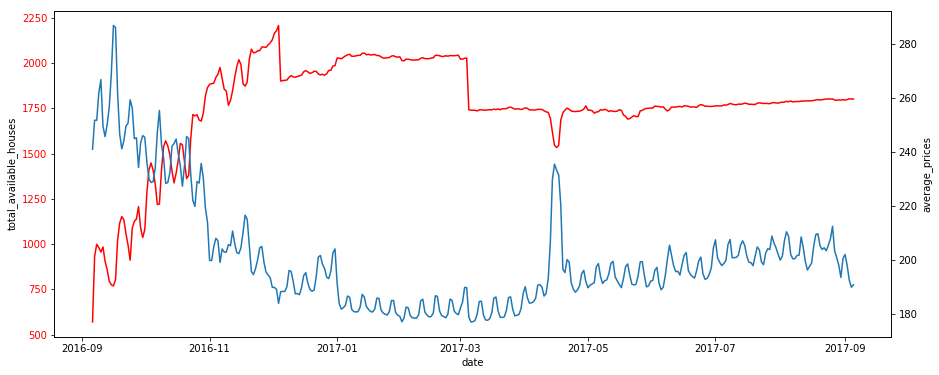

In [172]:
# plot total available houses and average prices in one figure
f, ax = plt.subplots(figsize=(15, 6))
plt1 = sns.lineplot(x = avaliable_count_bs.index,y = 'total_available_houses', 
                  data = avaliable_count_bs,color="r",legend=False)
for tl in ax.get_yticklabels():
    tl.set_color('r')

ax2 = ax.twinx()
plt2 = sns.lineplot(x = average_price_bs.index,y = 'average_prices',
             data=average_price_bs,ax=ax2,linestyle=':', legend=False)

**Figure Findings**

Total available houses:
1. Availability is not stable all year round.
2. Increase from Sep to Nov.
3. Remain relatively stable from 01/2017-09/2017, although the reason why there are two sudden drop of home supply is unclear.

Average prices:
1. Price drop as home supply increase from 09/2016 to 12/2016.
2. The sudden drop of supply in 03/2017 dose not drive price up;However the sudden drop of supply before 05/2017 just rocket price up. So I guess it has something to do with demand change.
3. There seems to have a small periodical price moving circle and this maybe correspond to weekends.

In [141]:
# take a closer look at the price spike before 05/2017
average_price_bs_sub = average_price_bs[average_price_bs.index > '2017-03-1']
average_price_bs_sub[average_price_bs_sub.average_prices == max(average_price_bs_sub.average_prices)]

,average_prices
date,
2017-04-15,235.501618


**Table Findings**
1. Aha, this timing is interesting becasue boston marathon of 2017 was held on 04-17,so there is strong evidence this sudden spike of price is due to the marathon event.

In [174]:
# average avaliablity for each house
avaliable_days_bs = bs_calendar.groupby('listing_id').apply(lambda x: x.notnull().mean())[['price']]
# change column name
avaliable_days_bs = avaliable_days_bs.rename({"price":"avaliable_ratio"},axis='columns')

Text(0, 0.5, 'count')

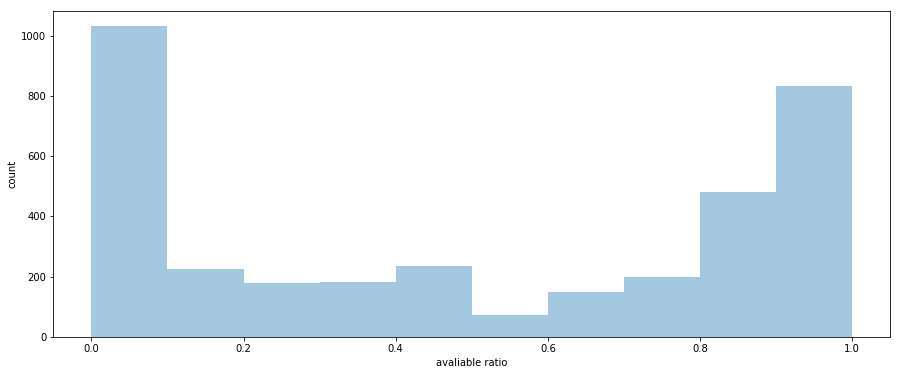

In [179]:
#avaliable_days_bs.head()
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.distplot(avaliable_days_bs, kde=False)
ax.set_xlabel('avaliable ratio', fontsize=10)
ax.set_ylabel('count', fontsize=10)
# a large portion of houses are available for a small portion of days

**Figure Findings**
1. Most Boston host just list their homes for a small portion of year.

In [127]:
# check general price distribution
bs_calendar_open.describe()

,listing_id,price
count,6.430370e+05,643037.000000
mean,7.699288e+06,198.438909
std,4.766178e+06,180.142913
min,3.353000e+03,11.000000
25%,3.616081e+06,85.000000
50%,7.789055e+06,150.000000
75%,1.228796e+07,255.000000
max,1.493346e+07,7163.000000


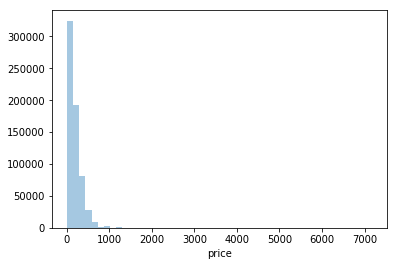

In [129]:
sns.distplot(bs_calendar_open.price, kde=False)
# price large than 1000 is pretty rare

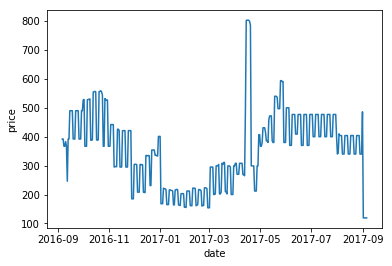

In [24]:
# visualize price change pattern for a particular listing 
list_price_eg = bs_calendar_open[bs_calendar_open.listing_id == 14421304]
sns.lineplot(x="date",y="price", data=list_price_eg)

# Q2: What’s the business growth trend?

## General trend

In [180]:
# host since house count
bs_cumhost = bs_listing.groupby('host_since').count()[['id']]
# change column name
bs_cumhost = bs_cumhost.rename({"id":"house_num"},axis='columns')

In [181]:
# get cumulative house numbers
bs_cumhost['cum_house_num'] = bs_cumhost.house_num.cumsum()
bs_cumhost.head()

,house_num,cum_house_num
host_since,,
2008-11-11,2,2
2008-12-03,1,3
2009-02-16,1,4
2009-02-17,1,5
2009-02-19,6,11


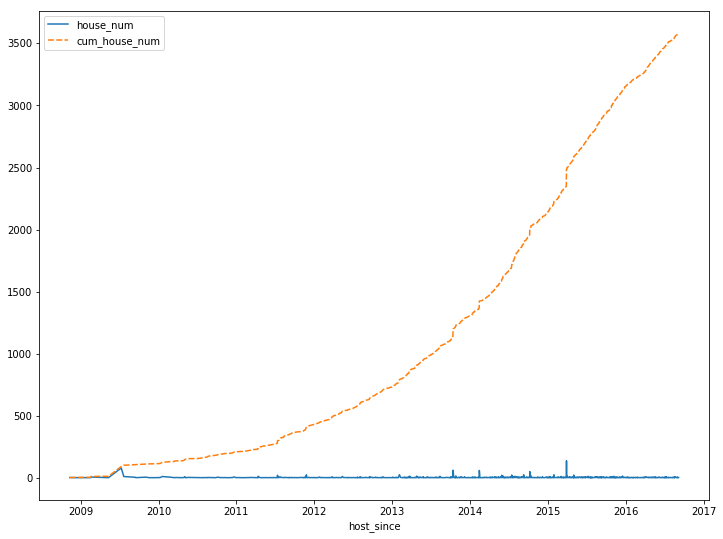

In [182]:
f, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(data=bs_cumhost)

**Figure Findings**
1. Cummulativ house numbers grows exponentially

## District Trend

In [183]:
# creat year_month column to group district growth into year_month period
bs_listing['year_month'] = bs_listing.host_since.dt.to_period('M')

In [238]:
def cum_listing_for_cat(colname,bs_listing=bs_listing):
    '''
    This function is used to get the cummulative listing on different categorys over year_month
    
    INPUT:
    colname - str, the categorical column you want to cummulate
    bs_listing - data.frame,bs listing data
    
    OUTPUT:
    df - a new dataframe that has the following columns:
            1. year_month
            2. colname,indicate category
            3. cum_listings
    '''
    col_listnum = bs_listing.groupby(['year_month',colname]).count()[['id']]
    col_listnum.reset_index(inplace=True)
    # calculate cumulative listing for each category
    col_listnum = col_listnum.sort_values(by=[colname,'year_month'])
    col_listnum['cumnum'] = col_listnum.groupby(by=[colname])['id'].apply(lambda x: x.cumsum())
    # drop unneeded column
    col_listnum.drop(['id'],inplace=True,axis=1)
    # long to wide
    # notice that for each category there are some year_month without any record
    # need to flattern the data make sure every neighborhood has all the year_month record.
    # fill na with the last non na value
    col_listnum_wide = col_listnum.pivot('year_month', colname)
    col_listnum_wide = col_listnum_wide.fillna(method='ffill')
    col_listnum_wide = col_listnum_wide.fillna(0)
    # rename columns prepare for wide to long
    col_listnum_wide.rename(columns=lambda x: 'col_'+x, inplace=True)
    # reset index
    col_listnum_wide.reset_index(inplace=True)
    # remove first row
    col_listnum_wide_clean = col_listnum_wide['col_cumnum']
    col_listnum_wide_clean['year_month'] = col_listnum_wide['year_month']
    # change this wide data to long again for drawing figures
    col_listnum_wide_long = col_listnum_wide_clean.melt('year_month', var_name='cols',  value_name='vals')
    col_listnum_wide_long = col_listnum_wide_long.rename(columns={"cols": colname, "vals": "cum_listings"})
    return col_listnum_wide_long

In [242]:
neighbor_cum_listing = cum_listing_for_cat('neighbourhood_cleansed',bs_listing=bs_listing)
neighbor_cum_listing.head()

,year_month,neighbourhood_cleansed,cum_listings
0,2008-11,col_Allston,2.0
1,2008-12,col_Allston,2.0
2,2009-02,col_Allston,2.0
3,2009-05,col_Allston,2.0
4,2009-07,col_Allston,2.0


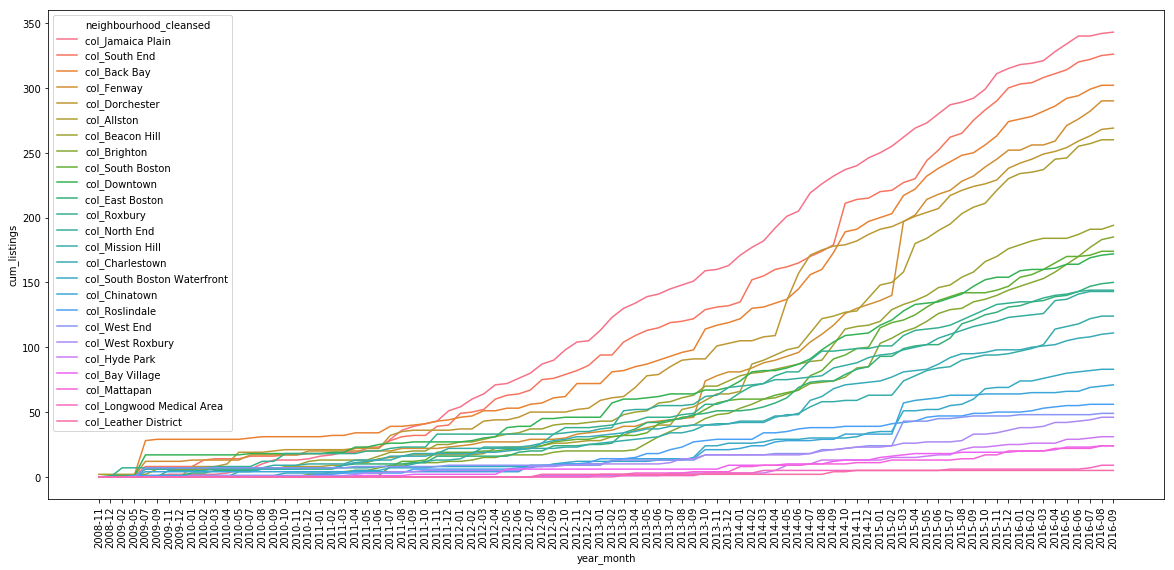

In [243]:
f, ax = plt.subplots(figsize=(20, 9))
# change year_month column from type datetime to str to draw figure
neighbor_cum_listing.year_month = neighbor_cum_listing.year_month.apply(lambda x:str(x))
# make sure legend order is ordered by cum listing values
last_date = neighbor_cum_listing[neighbor_cum_listing.year_month==max(neighbor_cum_listing.year_month)]
hue_order = last_date.sort_values(by=['cum_listings'],ascending=False)['neighbourhood_cleansed']
g=sns.lineplot(x='year_month',y='cum_listings',hue='neighbourhood_cleansed', hue_order =hue_order ,
               data=neighbor_cum_listing)
g=g.set_xticklabels(neighbor_cum_listing.year_month.unique(),rotation=90)

**Figure Findings**
1. District with the most listings is Jamaica Plain
2. And Jamaica Plain wasn't the district with most listings in early years.
3. Some district remain low listings over the years.

## Price Level Trend

In [244]:
# how different price level homes increase in numbers over the years?
# first see price distribution
bs_listing.price.describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

In [251]:
# use 25% price value as low price bar; 75% price value as high price bar
def price_level(x,low_bar=85,high_bar=220):
    if x<=low_bar:
        x='Low_Price'
    elif x>=high_bar:
        x='High_Price'
    else:
        x='Medium_Price'
    return x
bs_listing['price_level'] = bs_listing.price.apply(price_level)

In [252]:
price_level_listnum_wide_long = cum_listing_for_cat('price_level',bs_listing=bs_listing)

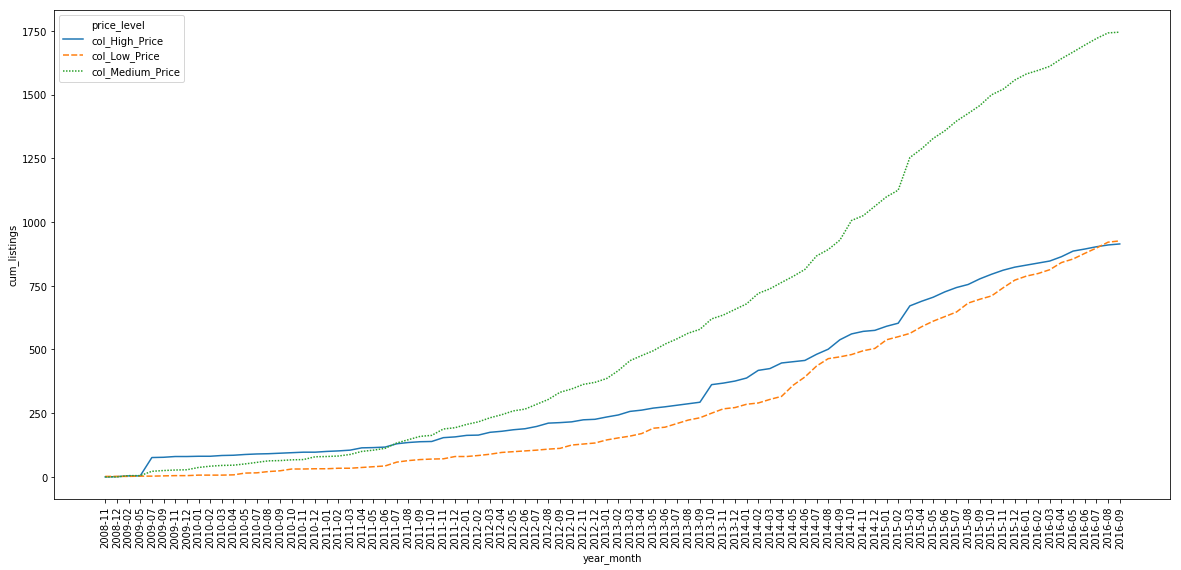

In [254]:
f, ax = plt.subplots(figsize=(20, 9))
# change year_month column from type datetime to str to draw figure
price_level_listnum_wide_long.year_month = price_level_listnum_wide_long.year_month.apply(lambda x:str(x))
g=sns.lineplot(x='year_month',y='cum_listings',hue='price_level',style='price_level',
               data=price_level_listnum_wide_long)
g=g.set_xticklabels(price_level_listnum_wide_long.year_month.unique(),rotation=90)

**Figure Findings**
1. Medium price homes grew faster than in terms of total lising numbers.
2. At early years it was high price listings that had the most listings.

# Q3: How price and rating relate with each other?

In [255]:
# select price and ratings and dropna
bs_price_rate = bs_listing[["id","price","review_scores_rating","number_of_reviews"]].dropna()
bs_price_rate.head()

,id,price,review_scores_rating,number_of_reviews
1,3075044,65.0,94.0,36
2,6976,65.0,98.0,41
3,1436513,75.0,100.0,1
4,7651065,79.0,99.0,29
5,12386020,75.0,100.0,8


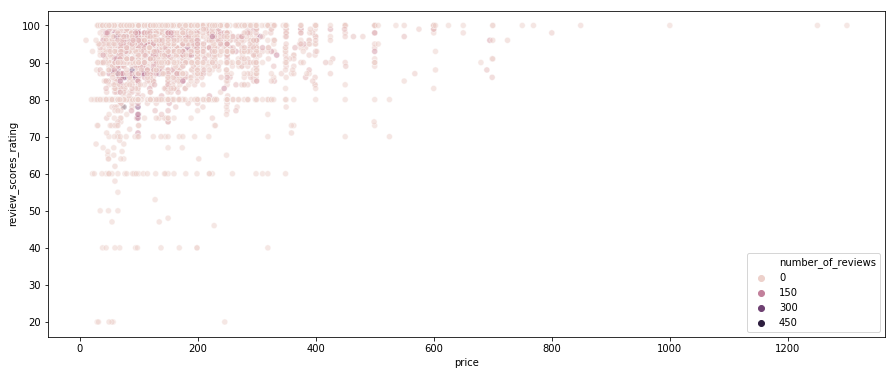

In [256]:
f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='price',y='review_scores_rating',hue='number_of_reviews',alpha=0.5,data=bs_price_rate)
# low ratings are associate with lower prices.
# however high rating dose not mean high price

In [46]:
bs_price_rate.describe()

,id,price,review_scores_rating,number_of_reviews
count,2.772000e+03,2772.000000,2772.000000,2772.000000
mean,7.627088e+06,166.684343,91.916667,24.606782
std,4.386274e+06,112.972898,9.531686,38.730995
min,3.353000e+03,11.000000,20.000000,1.000000
25%,4.078974e+06,85.000000,89.000000,3.000000
50%,7.713772e+06,145.000000,94.000000,10.000000
75%,1.175728e+07,215.000000,98.250000,29.000000
max,1.484378e+07,1300.000000,100.000000,404.000000


In [82]:
# find the listing with the highest number of reviews
max_id = bs_price_rate[bs_price_rate.number_of_reviews == max(bs_price_rate.number_of_reviews)]
max_id

,id,price,review_scores_rating,number_of_reviews
414,66288,75.0,78.0,404


In [76]:
# info of this listing
bs_listing[bs_listing.id== 66288].T

,414
id,66288
listing_url,https://www.airbnb.com/rooms/66288
scrape_id,20160906204935
last_scraped,2016-09-07
name,Architects Live-in Studio in Boston
summary,NaN
space,"Apartment now has permanent, hi-speed cable in..."
description,"Apartment now has permanent, hi-speed cable in..."
experiences_offered,none
neighborhood_overview,NaN


In [81]:
bs_calendar[bs_calendar.listing_id==66288 ].count()

listing_id    365
date          365
available     365
price         281
dtype: int64

# Price Influence Factors

In [47]:
# keep listings with not null prices
bs_listing_price = bs_listing[bs_listing.price.notnull()]
bs_listing_price.price = bs_listing_price.price.apply(remove_dollar)

In [48]:
# price and neighborhood
price_area = bs_listing_price.groupby('neighbourhood_cleansed').mean()[['price']]
price_area.reset_index(inplace=True)

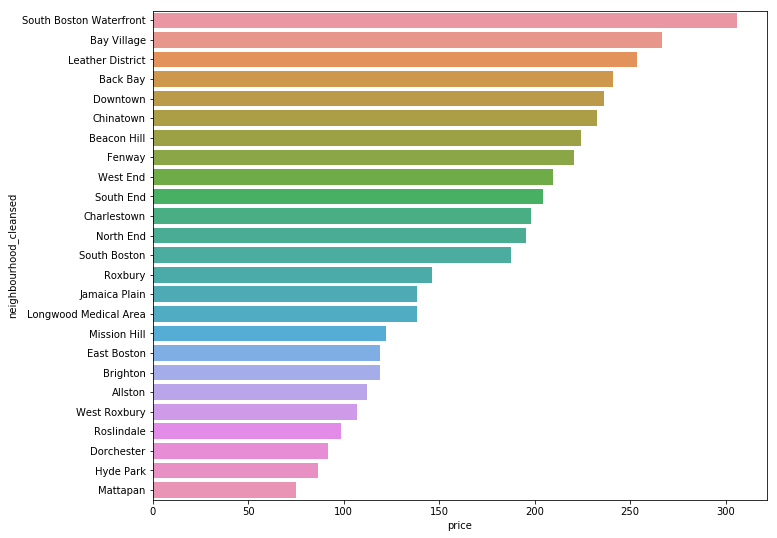

In [83]:
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(y='neighbourhood_cleansed',x='price',data=price_area.sort_values(by='price', ascending=False))

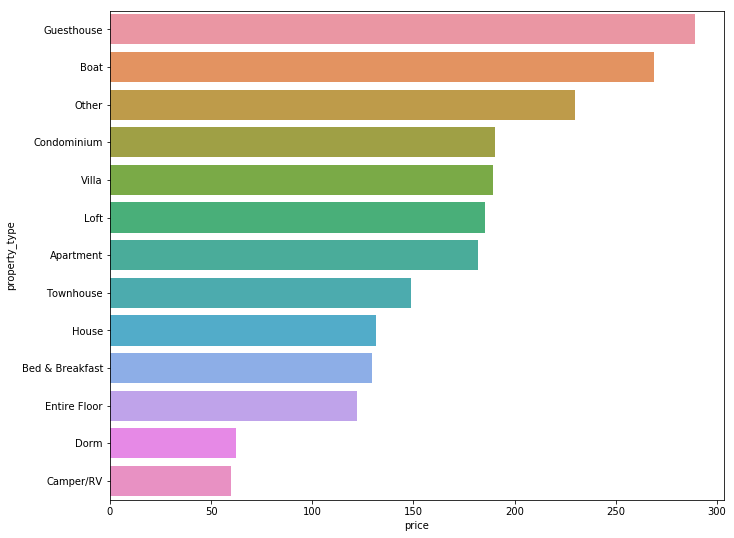

In [84]:
# price and property type
price_property_type = bs_listing_price.groupby('property_type').mean()[['price']]
price_property_type.reset_index(inplace=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(y='property_type',x='price',data=price_property_type.sort_values(by='price', ascending=False))

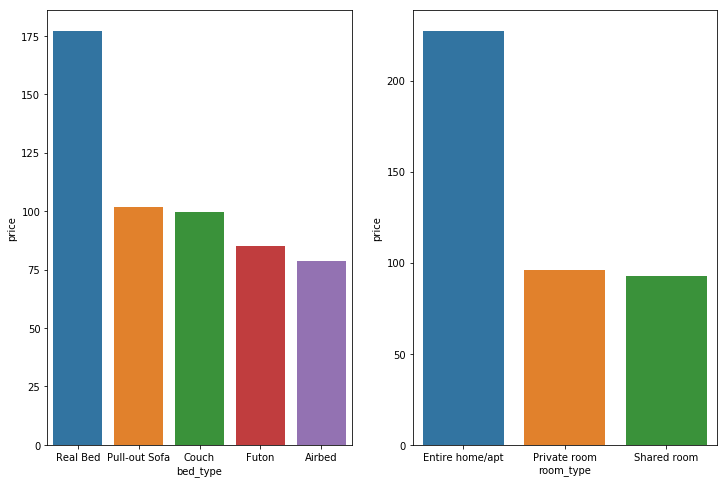

In [89]:
# price and bed_type
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
price_bed_type = bs_listing_price.groupby('bed_type').mean()[['price']]
price_bed_type.reset_index(inplace=True)
sns.barplot(x='bed_type',y='price',data=price_bed_type.sort_values(by='price', ascending=False),ax=ax1)
# price and bed_type
price_room_type = bs_listing_price.groupby('room_type').mean()[['price']]
price_room_type.reset_index(inplace=True)
sns.barplot(x='room_type',y='price',data=price_room_type.sort_values(by='price', ascending=False),ax=ax2)

In [54]:
# see how numerical values correlate with price
bs_listing_price_num = bs_listing_price.select_dtypes(include=['float64','int'])

In [55]:
bs_listing_price_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 3584
Data columns (total 34 columns):
id                                3585 non-null int64
scrape_id                         3585 non-null int64
host_id                           3585 non-null int64
host_listings_count               3585 non-null int64
host_total_listings_count         3585 non-null int64
neighbourhood_group_cleansed      0 non-null float64
latitude                          3585 non-null float64
longitude                         3585 non-null float64
accommodates                      3585 non-null int64
bathrooms                         3571 non-null float64
bedrooms                          3575 non-null float64
beds                              3576 non-null float64
square_feet                       56 non-null float64
price                             3585 non-null float64
guests_included                   3585 non-null int64
minimum_nights                    3585 non-null int64
maximum_nights    

In [56]:
# drop irrelevent colunms
bs_listing_price_num = bs_listing_price_num.drop(['id','scrape_id','host_id','latitude','longitude','jurisdiction_names',
                          'neighbourhood_group_cleansed','license','has_availability','neighbourhood_group_cleansed'], axis=1)

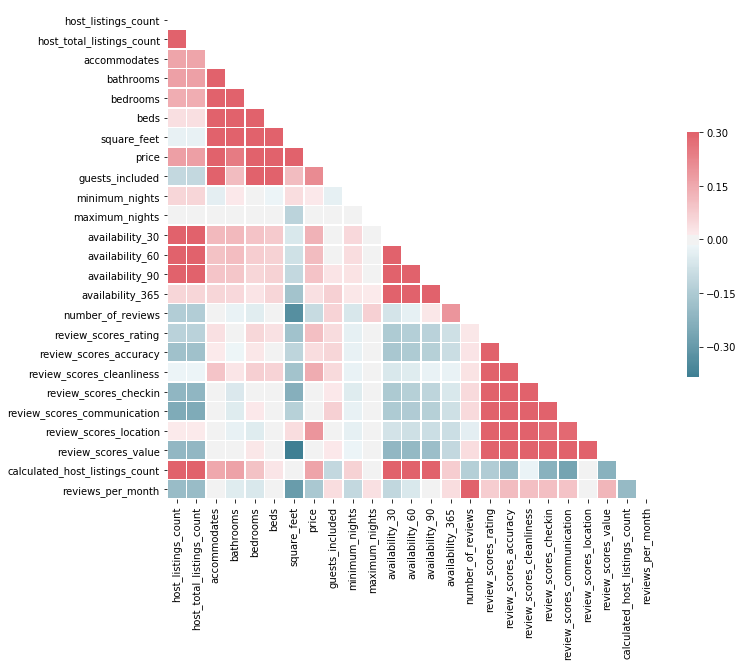

In [57]:
corr = bs_listing_price_num.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})